In [ ]:
!pip install -U albumentations

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from tqdm.auto import tqdm
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import random
import glob
import albumentations as A
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = '../input/chest-xray-pneumonia/chest_xray/'
categories = ['train', 'test', 'val']
data = {cat: glob.glob(os.path.join(data_dir, cat, '**/*.jpeg')) for cat in categories}

print(f"Training Set has: {len(data['train'])} images")
print(f"Testing Set has: {len(data['test'])} images")
print(f"Validation Set has: {len(data['val'])} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


In [4]:
all_pneumonia = []
all_normal = []

for cat in categories:
    path = os.path.join(data_dir, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


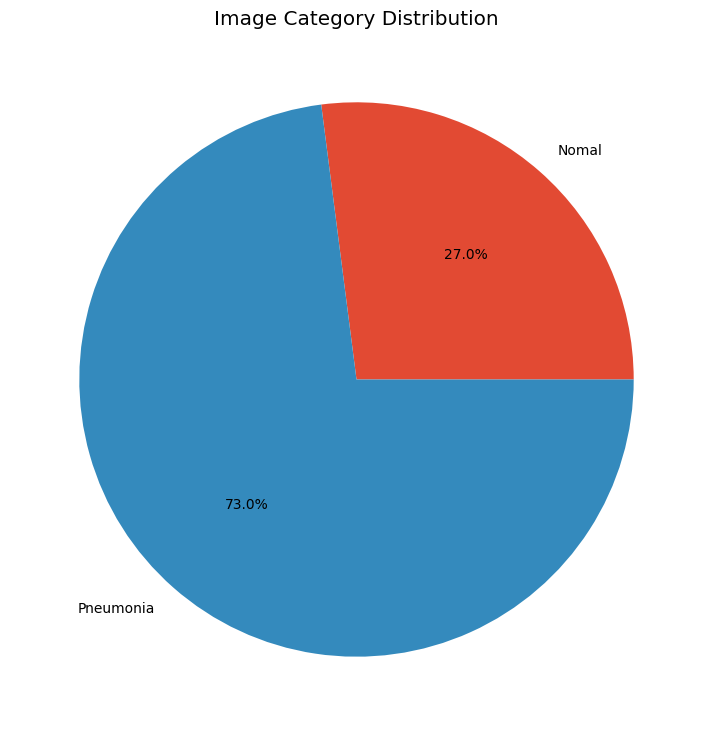

In [5]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

In [6]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

In [ ]:
fig=plt.figure(figsize=(12, 10))
rows = 5
columns = 4
for i in range(columns * rows):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis(False)

## Ben Graham's Method

In [ ]:
fig=plt.figure(figsize=(15, 8))
rows = 2
for i in range(columns * rows):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis(False)

## Fourier Transform for Pixel Distribution

In [9]:
fig=plt.figure(figsize=(15, 8))
for i in range(columns * rows):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

## Albumentations Visualization

In [10]:
def plot_multiple_img(img_matrix_list, titles_list, ncols=4, main_title="Different Types of Augmentations"):
    n_images = len(img_matrix_list)
    nrows = (n_images + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = axes.flatten()

    for i in range(len(axes)):
        if i < n_images:
            img = img_matrix_list[i]
            if isinstance(img, torch.Tensor):  # Handle torch tensors.
                img = img.permute(1, 2, 0).squeeze().cpu().numpy()  # Convert to numpy.
            axes[i].imshow(img, cmap='gray' if img.ndim == 2 else None)
            axes[i].set_title(titles_list[i], fontsize=10)
        axes[i].axis('off') 

    for i in range(n_images, len(axes)):
        axes[i].axis('off')  

    fig.suptitle(main_title, fontsize=16, weight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88) 
    plt.show()


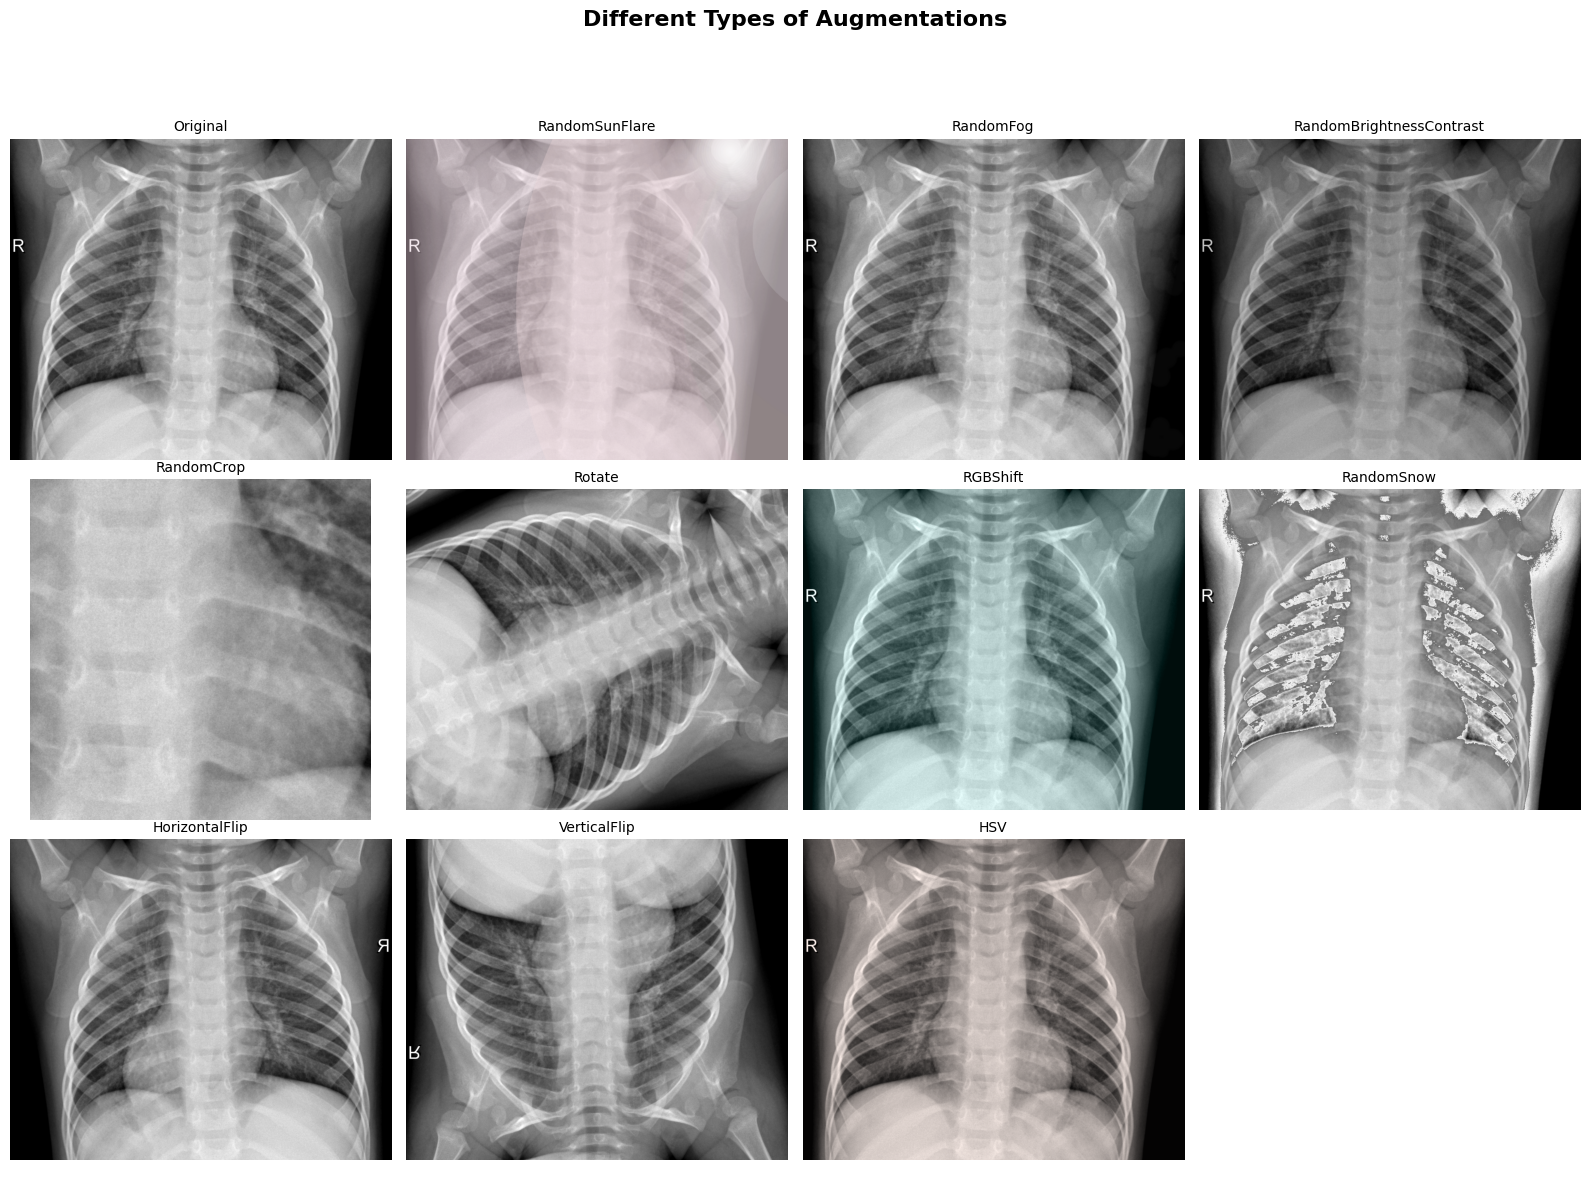

In [11]:
chosen_image = cv2.imread(images[21])

albumentation_list = [
    A.RandomSunFlare(p=1), 
    A.RandomFog(p=1), 
    A.RandomBrightnessContrast(p=1),  
    A.RandomCrop(p=1, height=512, width=512), 
    A.Rotate(p=1, limit=90),
    A.RGBShift(p=1), 
    A.RandomSnow(p=1),
    A.HorizontalFlip(p=1), 
    A.VerticalFlip(p=1), 
    A.HueSaturationValue(p=1, hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)
]

img_matrix_list = [chosen_image]
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image=chosen_image)['image']
    img_matrix_list.append(img)

titles_list = [
    "Original", "RandomSunFlare", "RandomFog", "RandomBrightnessContrast", 
    "RandomCrop", "Rotate", "RGBShift", "RandomSnow", 
    "HorizontalFlip", "VerticalFlip", "HSV"
]
plot_multiple_img(img_matrix_list, titles_list, ncols=4, main_title="Different Types of Augmentations")

## Image Erosion

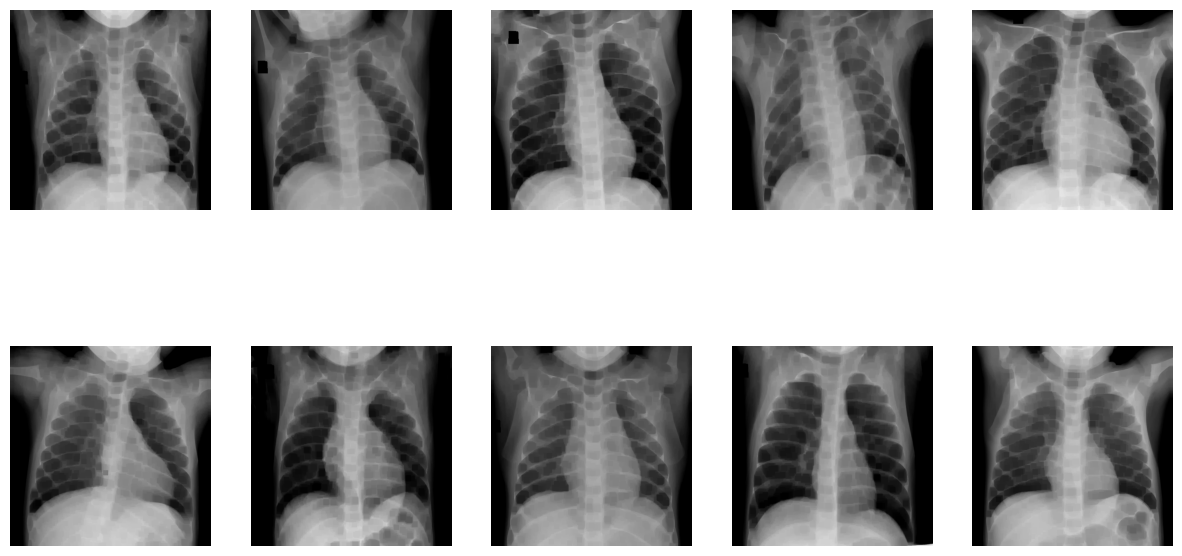

In [12]:
fig = plt.figure(figsize=(15, 8))
columns = 5
for i in range(columns * rows):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img_erosion)
    plt.axis(False)

## Image Dilation

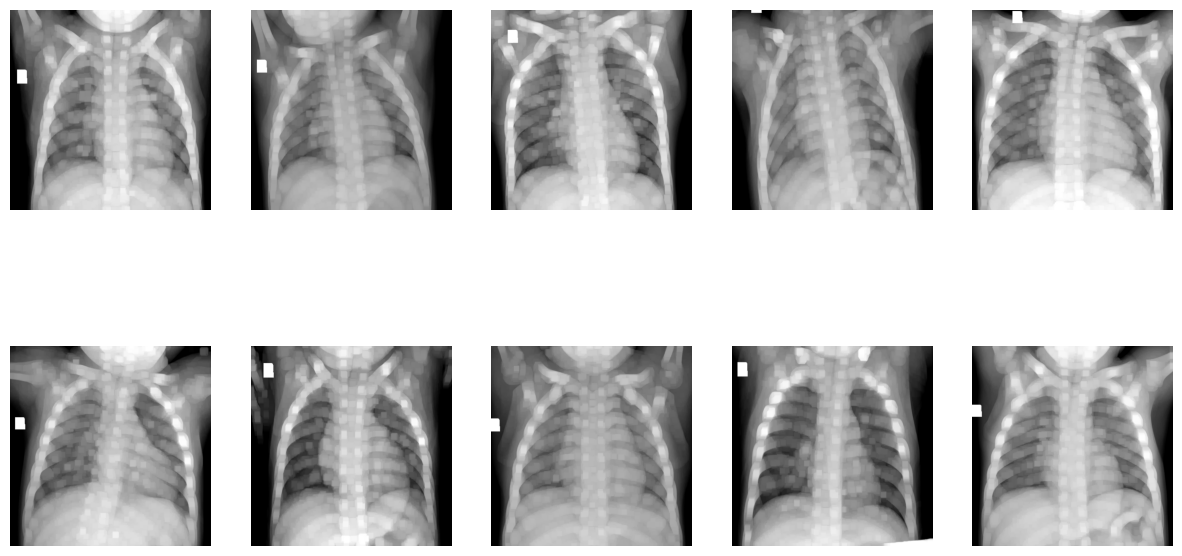

In [13]:
fig = plt.figure(figsize=(15, 8))
for i in range(columns * rows):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img_erosion)
    plt.axis(False)

## Canny Edge Detection

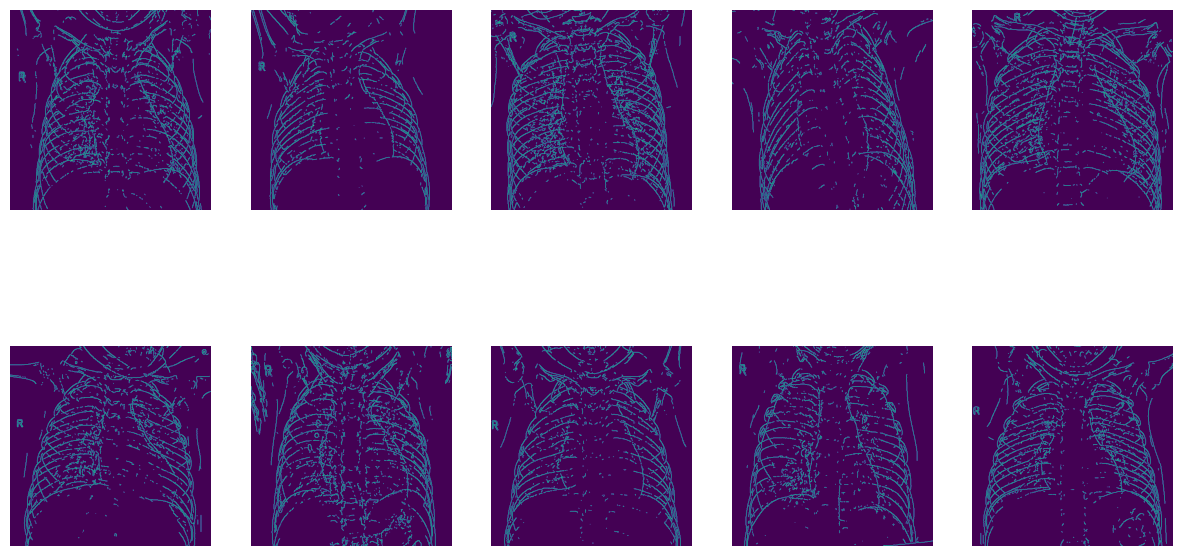

In [14]:
fig = plt.figure(figsize=(15, 8))
for i in range(columns * rows):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(edges)
    plt.axis(False)

## Modeling

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_channel, hidden_dim=64):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            self._block(latent_dim, hidden_dim*16, 4, 1, 0), 
            self._block(hidden_dim*16, hidden_dim*8, 4, 2, 1),
            self._block(hidden_dim*8, hidden_dim*4, 4, 2, 1),
            self._block(hidden_dim*4, hidden_dim*2, 4, 2, 1),
            self._block(hidden_dim*2, hidden_dim, 4, 2, 1),
            nn.ConvTranspose2d(hidden_dim, output_channel, 4, 2, 1),
            nn.Tanh()
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.gen(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_channel, hidden_dim=64):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            self._block(input_channel, hidden_dim, 4, 2, 1),
            self._block(hidden_dim, hidden_dim*2, 4, 2, 1),
            self._block(hidden_dim*2, hidden_dim*4, 4, 2, 1),
            self._block(hidden_dim*4, hidden_dim*8, 4, 2, 1),
            self._block(hidden_dim*8, hidden_dim*16, 4, 2, 1),
            nn.Conv2d(hidden_dim*16, 1, 4, 1, 0),
        )
            
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )
    
    def forward(self, x):
        return self.disc(x)
        

In [16]:
latent_dim = 100
im_channels = 1
im_size = 128

epochs = 150
batch_size = 32
learning_rate = 2e-4
lambda_gp = 10
n_critic = 5
betas = (0.3, 0.99)

device = "cuda" if torch.cuda.is_available() else "cpu"
display_epoch = 10

result_dir = "./results"

In [17]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples_per_class=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        for label, subdir in enumerate(['PNEUMONIA', 'NORMAL']):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.exists(subdir_path):
                all_images = [os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith(('jpeg', 'png', 'jpg', 'bmp', 'tiff'))]
                
                if len(all_images) > num_samples_per_class:
                    all_images = random.sample(all_images, num_samples_per_class)
                self.image_files.extend(all_images)
                self.labels.extend([label] * len(all_images))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [18]:
def load_data(data_dir, batch_size, im_channels, im_size):
    # Define transforms
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=im_channels),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(im_channels)], [0.5 for _ in range(im_channels)])
    ])
    dataset = CustomDataset(data_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return data_loader

dataloader = load_data(os.path.join(data_dir, 'train'), batch_size, im_channels, im_size)

In [19]:
def weights_init(model):
    if isinstance(model, (nn.Conv2d, nn.ConvTranspose2d)):
        model.weight.data.normal_(0.0, 0.02) # xavier_normalization
    if isinstance(model, (nn.BatchNorm2d)):
        model.weight.data.normal_(0.0, 0.02)
        model.bias.data.fill_(0)

def gradient_penalty(critic, real, fake, device='cpu'):
    epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
    interpolated_images = real * epsilon + fake * (1 - epsilon)
    
    mixed_scores = critic(interpolated_images)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [20]:
gen = Generator(latent_dim, im_channels).to(device)
gen_optim = optim.Adam(gen.parameters(), lr=learning_rate, betas=betas)
gen = gen.apply(weights_init)

print(gen)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

In [21]:
critic = Discriminator(im_channels).to(device)
critic_optim = optim.Adam(critic.parameters(), lr=learning_rate, betas=betas)
critic = critic.apply(weights_init)

print(critic)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

In [25]:
def plot_images(fake, epoch):
    im_grid_fake = make_grid(fake[:16], nrow=4, normalize=True)
    plt.imshow(im_grid_fake.permute(1, 2, 0).squeeze().cpu())
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch + 1}")
    plt.show()

In [29]:
def train(gen, critic, gen_optim, critic_optim, dataloader, device):
    step_bins = 20
    step = 0
    gen_losses, critic_losses = [], []
    fixed_noise = torch.randn((batch_size, latent_dim, 1, 1)).to(device)

    for epoch in range(epochs):
        batch_idx = 0
        print(f'[INFO] training epoch {epoch+1}...')
        for real, _ in tqdm(dataloader):
            real = real.to(device)
            mean_critic_loss = 0

            # Train Critic
            for _ in range(n_critic):
                noise = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
                fake = gen(noise)

                critic_real = critic(real)
                critic_fake = critic(fake)
                gp = gradient_penalty(critic, real, fake, device)
                critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp

                critic.zero_grad()
                critic_loss.backward(retain_graph=True)
                critic_optim.step()

                mean_critic_loss += critic_loss.item() / n_critic

            critic_losses.append(mean_critic_loss)

            # Train Generator
            noise = torch.randn((batch_size, latent_dim, 1, 1)).to(device)
            fake = gen(noise)
            output = critic(fake)
            gen_loss = -torch.mean(output)

            gen.zero_grad()
            gen_loss.backward()
            gen_optim.step()

            gen_losses.append(gen_loss.item())
            
            batch_idx += 1
            step += 1
            
        if (epoch + 1) % display_epoch == 0:
            print(f"[{epoch+1}/{epochs}][{batch_idx}/{len(dataloader)}] \
                    Loss D: {critic_loss:.4f}, loss G: {gen_loss:.4f}")
            with torch.no_grad():
                fake = gen(fixed_noise)
                plot_images(fake, epoch)

        if step % 200 == 0:
            num_examples = (len(gen_losses) // step_bins) * step_bins

            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(gen_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

[INFO] training epoch 1...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 2...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 3...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 4...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 5...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 6...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 7...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 8...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 9...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 10...


  0%|          | 0/62 [00:00<?, ?it/s]

[10/150][62/62]                     Loss D: -11.3734, loss G: 22.9722


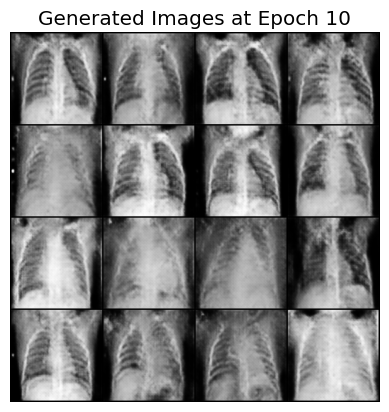

[INFO] training epoch 11...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 12...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 13...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 14...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 15...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 16...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 17...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 18...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 19...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 20...


  0%|          | 0/62 [00:00<?, ?it/s]

[20/150][62/62]                     Loss D: -8.1825, loss G: 27.2567


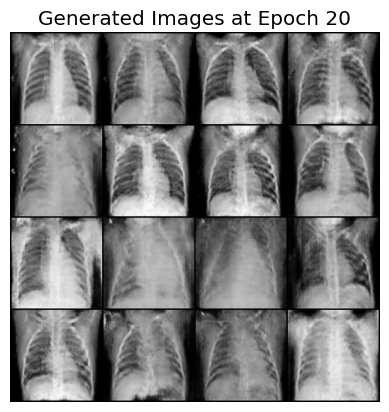

[INFO] training epoch 21...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 22...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 23...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 24...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 25...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 26...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 27...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 28...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 29...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 30...


  0%|          | 0/62 [00:00<?, ?it/s]

[30/150][62/62]                     Loss D: -4.6103, loss G: 19.2255


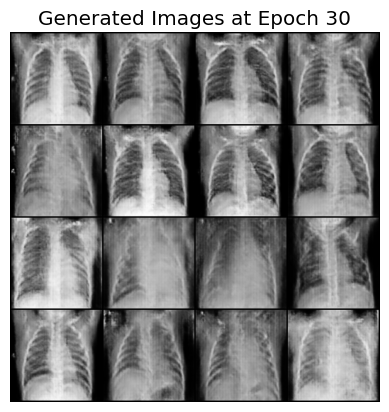

[INFO] training epoch 31...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 32...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 33...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 34...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 35...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 36...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 37...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 38...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 39...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 40...


  0%|          | 0/62 [00:00<?, ?it/s]

[40/150][62/62]                     Loss D: -16.1027, loss G: 22.2032


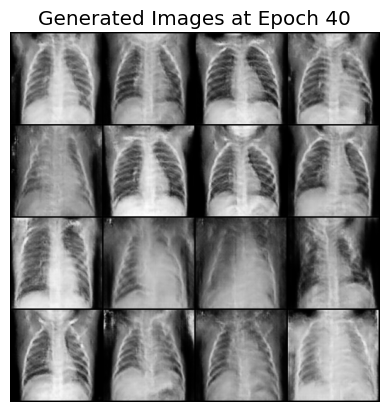

[INFO] training epoch 41...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 42...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 43...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 44...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 45...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 46...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 47...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 48...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 49...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 50...


  0%|          | 0/62 [00:00<?, ?it/s]

[50/150][62/62]                     Loss D: -5.3016, loss G: 29.2895


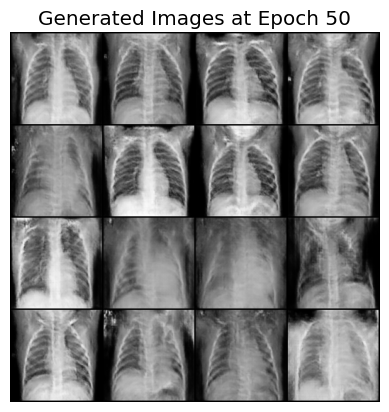

[INFO] training epoch 51...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 52...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 53...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 54...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 55...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 56...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 57...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 58...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 60...


  0%|          | 0/62 [00:00<?, ?it/s]

[60/150][62/62]                     Loss D: -26.6928, loss G: 40.1778


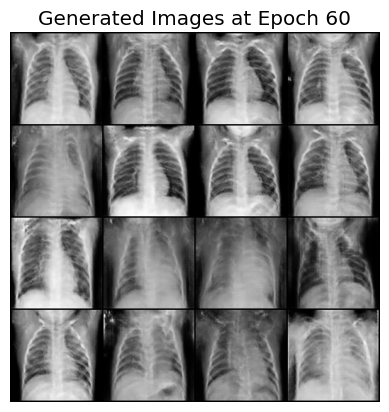

[INFO] training epoch 61...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 62...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 63...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 64...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 65...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 66...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 67...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 68...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 69...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 70...


  0%|          | 0/62 [00:00<?, ?it/s]

[70/150][62/62]                     Loss D: -18.5135, loss G: 26.7100


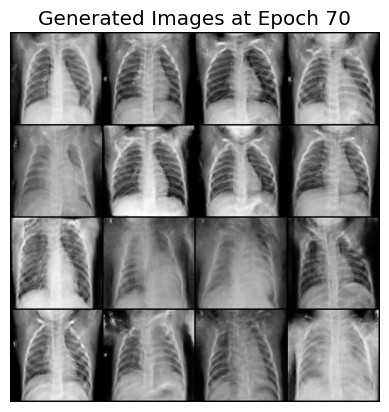

[INFO] training epoch 71...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 72...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 73...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 74...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 75...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 76...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 77...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 78...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 79...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 80...


  0%|          | 0/62 [00:00<?, ?it/s]

[80/150][62/62]                     Loss D: -5.5995, loss G: 32.3272


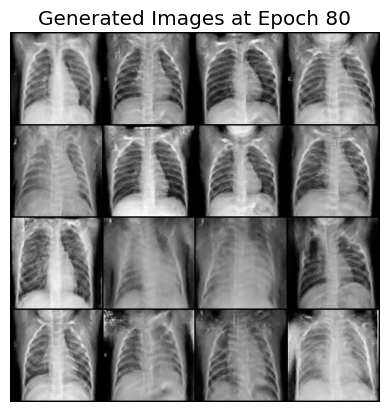

[INFO] training epoch 81...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 82...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 83...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 84...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 85...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 86...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 87...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 88...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 89...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 90...


  0%|          | 0/62 [00:00<?, ?it/s]

[90/150][62/62]                     Loss D: -8.2325, loss G: 24.2528


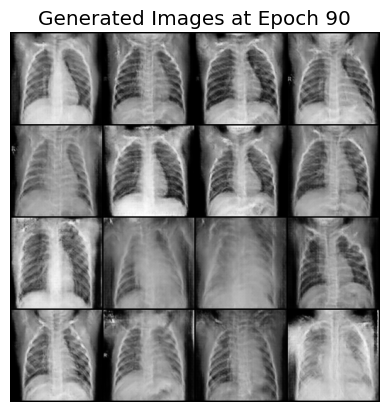

[INFO] training epoch 91...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 92...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 93...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 94...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 95...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 96...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 97...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 98...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 99...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 100...


  0%|          | 0/62 [00:00<?, ?it/s]

[100/150][62/62]                     Loss D: -9.7290, loss G: 31.0399


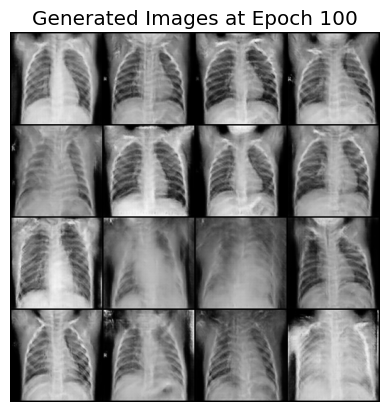

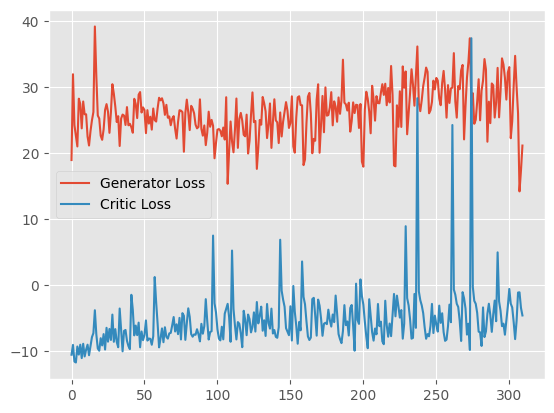

[INFO] training epoch 101...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 102...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 103...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 104...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 105...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 106...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 107...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 108...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 109...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 110...


  0%|          | 0/62 [00:00<?, ?it/s]

[110/150][62/62]                     Loss D: -18.2112, loss G: 18.5563


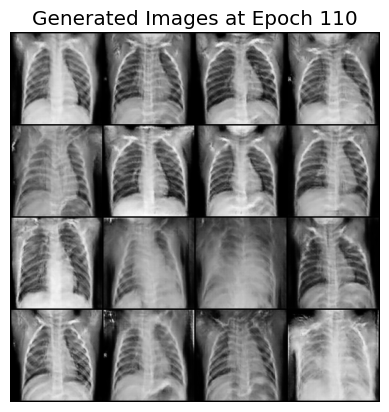

[INFO] training epoch 111...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 112...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 113...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 114...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 115...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 116...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 117...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 118...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 119...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 120...


  0%|          | 0/62 [00:00<?, ?it/s]

[120/150][62/62]                     Loss D: -10.3262, loss G: 44.2863


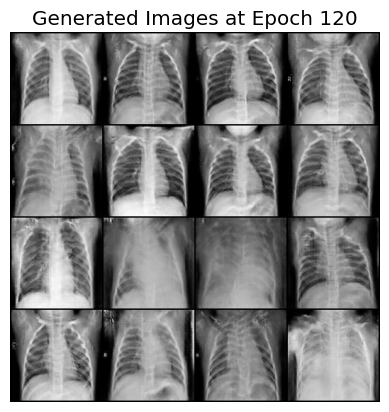

[INFO] training epoch 121...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 122...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 123...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 124...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 125...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 126...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 127...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 128...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 129...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 130...


  0%|          | 0/62 [00:00<?, ?it/s]

[130/150][62/62]                     Loss D: -7.3791, loss G: 40.1422


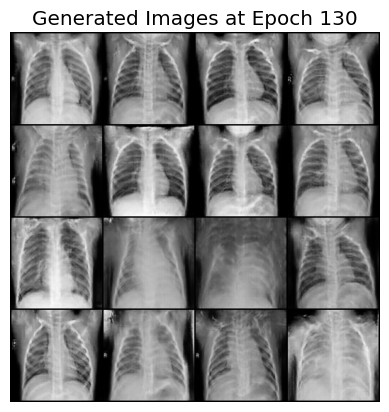

[INFO] training epoch 131...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 132...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 133...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 134...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 135...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 136...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 137...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 138...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 139...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 140...


  0%|          | 0/62 [00:00<?, ?it/s]

[140/150][62/62]                     Loss D: -7.0764, loss G: 37.1554


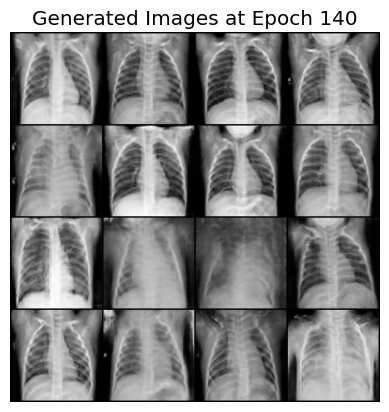

[INFO] training epoch 141...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 142...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 143...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 144...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 145...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 146...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 147...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 148...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 149...


  0%|          | 0/62 [00:00<?, ?it/s]

[INFO] training epoch 150...


  0%|          | 0/62 [00:00<?, ?it/s]

[150/150][62/62]                     Loss D: -4.0972, loss G: 36.6865


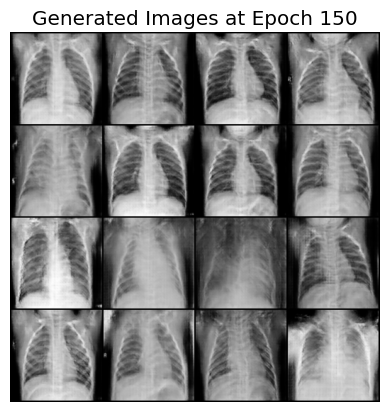

In [30]:
train(gen, critic, gen_optim, critic_optim, dataloader, device=device)

In [31]:
# Save the generator model from the last epoch
torch.save(gen.state_dict(), 'last_epoch_generator.pth')

# Save the critic model from the last epoch
torch.save(critic.state_dict(), 'last_epoch_critic.pth')

print("Models from the last epoch have been saved successfully.")

Models from the last epoch have been saved successfully.
